In [1]:
from tensorflow.keras.utils import image_dataset_from_directory

2022-03-04 11:49:16.715890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 11:49:16.715950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset = image_dataset_from_directory(
            "celeba_gan",
            label_mode=None,
            image_size=(64, 64),
            batch_size=32,
            smart_resize=True) 

Found 202599 files belonging to 1 classes.


2022-03-04 11:49:25.658636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-04 11:49:25.658698: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-04 11:49:25.658726: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc-portable): /proc/driver/nvidia/version does not exist
2022-03-04 11:49:25.661046: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = dataset.map(lambda x: x / 255.)

In [4]:
import matplotlib.pyplot as plt

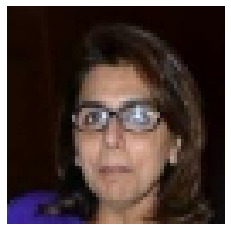

In [5]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [19]:
x.numpy()[0].shape

(64, 64, 3)

In [6]:
from tensorflow.keras import layers, Sequential, Input, Model

In [7]:

discriminator = Sequential(
    [
    Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [9]:
latent_dim = 128

generator = Sequential(
    [
    Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [11]:
from tensorflow import shape as tf_shape
from tensorflow.random import normal as tf_random_normal
from tensorflow.random import uniform as tf_random_uniform
from tensorflow import concat as tf_concat
from tensorflow import ones as tf_ones
from tensorflow import zeros as tf_zeros
from tensorflow import GradientTape
from tensorflow.keras.metrics import Mean as keras_mean
from tensorflow.keras.optimizers import Adam

In [12]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras_mean(name="d_loss")
        self.g_loss_metric = keras_mean(name="g_loss")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf_shape(real_images)[0]
        random_latent_vectors = tf_random_normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf_concat([generated_images, real_images], axis=0)
        labels = tf_concat(
            [tf_ones((batch_size, 1)), tf_zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf_random_uniform(tf_shape(labels))
        
        with GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        random_latent_vectors = tf_random_normal(
            shape=(batch_size, self.latent_dim))
        
        misleading_labels = tf_zeros((batch_size, 1))
        
        with GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}

In [13]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import array_to_img

In [14]:
class GANMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf_random_normal(
        shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [15]:
from tensorflow.keras.losses import BinaryCrossentropy

In [16]:
epochs = 100
gan = GAN(discriminator=discriminator, generator=generator,
            latent_dim=latent_dim)

gan.compile(
    d_optimizer=Adam(learning_rate=0.0001),
    g_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/100
   5/6332 [..............................] - ETA: 17:23:46 - d_loss: 0.6697 - g_loss: 0.7639

KeyboardInterrupt: 